## Data Import and Exploration

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)

In [6]:
midwest_abbrs = ["IL", "IN", "IA", "KS", "MI", "MN", "MO", "NE", "ND", "OH", "SD", "WI"]
midwest_states = ["Illinois", "Indiana", "Iowa", "Kansas", "Michigan", "Minnesota", "Missouri", 
                  "Nebraska", "North Dakota", "Ohio", "South Dakota", "Wisconsin"]

project_state_abbrs = ["IL", "MI", "MO", "OH"]
project_state_names = ["Illinois", "Michigan", "Missouri", "Ohio"]

### Covid 19 Case Data from the New York Times
Generally pretty clean already, but let's just take a look and organize a bit

In [7]:
NYT_df = pd.read_csv("../Raw_Data/NYT-us-counties_updated.csv", parse_dates=["date"], dtype={'fips': str, 'cases': int})
NYT_df.shape

(1361956, 6)

In [8]:
NYT_df.describe(datetime_is_numeric=True)

,date,cases,deaths
count,1361956,1361956.00,1331729.00
mean,2020-10-28 17:16:01.289205248,4391.11,91.20
min,2020-01-21 00:00:00,0.00,0.00
25%,2020-07-16 00:00:00,97.00,1.00
50%,2020-10-30 00:00:00,639.00,12.00
75%,2021-02-12 00:00:00,2434.00,48.00
max,2021-05-27 00:00:00,1243985.00,33184.00
std,NaN,22519.07,589.93


Looks like cases data is pretty complete, but there are some NAs for deaths.  Let's investigate...

In [9]:
NYT_df[NYT_df["deaths"].isnull()].head()

,date,county,state,fips,cases,deaths
117486,2020-05-05,Adjuntas,Puerto Rico,72001,3,NaN
117487,2020-05-05,Aguada,Puerto Rico,72003,7,NaN
117488,2020-05-05,Aguadilla,Puerto Rico,72005,11,NaN
117489,2020-05-05,Aguas Buenas,Puerto Rico,72007,22,NaN
117490,2020-05-05,Aibonito,Puerto Rico,72009,13,NaN


According to the documentation, Puerto Rico didn't report deaths at the municipal level, which explains the NA.  That's okay because we'll be narrowing down to the Midwest anyways

Let's look at what other territories were included

In [10]:
np.unique(NYT_df["state"]) # Looks like we have Guam, Northern Mariana Islands, Puerto Rico

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho', 'Illinois',
       'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Northern Mariana Islands',
       'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virgin Islands', 'Virginia',
       'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

Cases and deaths data is cumulative, so let's add columns for new cases and death

In [11]:
NYT_df.sort_values(by=["state", "fips", "county", "date"], inplace=True)

NYT_df['new_cases'] = NYT_df.groupby(["state", "fips", "county"])['cases'].diff()
NYT_df['new_deaths'] = NYT_df.groupby(["state", "fips", "county"])['deaths'].diff()

# re-label old columns
NYT_df = NYT_df.rename(columns={"cases": "cumulative_cases", "deaths": "cumulative_deaths"})

NYT_df.head()

,date,county,state,fips,cumulative_cases,cumulative_deaths,new_cases,new_deaths
9480,2020-03-24,Autauga,Alabama,01001,1,0.00,NaN,NaN
10835,2020-03-25,Autauga,Alabama,01001,4,0.00,3.00,0.00
12367,2020-03-26,Autauga,Alabama,01001,6,0.00,2.00,0.00
14025,2020-03-27,Autauga,Alabama,01001,6,0.00,0.00,0.00
15803,2020-03-28,Autauga,Alabama,01001,6,0.00,0.00,0.00


Now lets filter just to midwest states:

In [12]:
NYT_midwest = NYT_df[NYT_df["state"].isin(midwest_states)]

NYT_midwest.shape

(441382, 8)

In [13]:
# Let's make sure every row got a new cases/deaths computed before we fill the first row (which is currently NA) 
# with the cumulative numbers 
NYT_county_counts = NYT_midwest.groupby(["state", "county"]).count()
NYT_county_counts

date  fips  cumulative_cases  cumulative_deaths  \
state     county                                                       
Illinois  Adams       434   434               434                434   
          Alexander   407   407               407                407   
          Bond        425   425               425                425   
          Boone       418   418               418                418   
          Brown       392   392               392                392   
...                   ...   ...               ...                ...   
Wisconsin Waukesha    443   443               443                443   
          Waupaca     427   427               427                427   
          Waushara    417   417               417                417   
          Winnebago   440   440               440                440   
          Wood        438   438               438                438   

                     new_cases  new_deaths  
state     county                            
Illinois  Adams            433         433  
          Alexander        406         406  
          Bond             424         424  
          Boone            417         417  
          Brown            391         391  
...                        ...         ...  
Wisconsin Waukesha         442         442  
          Waupaca          426         426  
          Waushara         416         416  
          Winnebago        439         439  
          Wood             437         437  

[1069 rows x 6 columns]

In [14]:
# Each county should have (# valued new cases) = (# valued dates) - 1
pd.set_option('display.max_rows', None)
NYT_county_counts[NYT_county_counts["new_cases"]!=NYT_county_counts["date"]-1]

date  fips  cumulative_cases  cumulative_deaths  \
state        county                                                         
Illinois     Unknown       316     0               316                316   
Indiana      Unknown         5     0                 5                  5   
Iowa         Unknown       392     0               392                392   
Kansas       Unknown       210     0               210                210   
Michigan     Unknown       427     0               427                427   
Minnesota    Unknown       428     0               428                428   
Missouri     Joplin        337     0               337                337   
             Kansas City   434     0               434                434   
             Unknown        38     0                38                 38   
Nebraska     Unknown       215     0               215                215   
North Dakota Unknown       366     0               366                366   
Ohio         Unknown        88     0                88                 88   
South Dakota Unknown         5     0                 5                  5   
Wisconsin    Unknown       133     0               133                133   

                          new_cases  new_deaths  
state        county                              
Illinois     Unknown              0           0  
Indiana      Unknown              0           0  
Iowa         Unknown              0           0  
Kansas       Unknown              0           0  
Michigan     Unknown              0           0  
Minnesota    Unknown              0           0  
Missouri     Joplin               0           0  
             Kansas City          0           0  
             Unknown              0           0  
Nebraska     Unknown              0           0  
North Dakota Unknown              0           0  
Ohio         Unknown              0           0  
South Dakota Unknown              0           0  
Wisconsin    Unknown              0           0

Looks like each state has a category for Unknown county (which doesn't have a FIPS code which is why new_cases/deaths wasn't calculated.

Kansas City and Joplin straddle multiple counties, which is why they don't have a FIPS code either.
Let's lump these two cities in with the county for which the bulk of the city is in:
- Kansas City -> Jackson County
- Joplin -> Jasper County

In [15]:
# print out before observations so we can check and double check after we collapse
NYT_midwest[(NYT_midwest["county"]=="Jackson") & (NYT_midwest["state"]=="Missouri")].sort_values(by=["date"]).head(10)

,date,county,state,fips,cumulative_cases,cumulative_deaths,new_cases,new_deaths
3497,2020-03-17,Jackson,Missouri,29095,2,0.00,NaN,NaN
4086,2020-03-18,Jackson,Missouri,29095,3,0.00,1.00,0.00
4805,2020-03-19,Jackson,Missouri,29095,3,0.00,0.00,0.00
5640,2020-03-20,Jackson,Missouri,29095,5,1.00,2.00,1.00
6628,2020-03-21,Jackson,Missouri,29095,5,1.00,0.00,0.00
7717,2020-03-22,Jackson,Missouri,29095,5,1.00,0.00,0.00
8905,2020-03-23,Jackson,Missouri,29095,10,1.00,5.00,0.00
10205,2020-03-24,Jackson,Missouri,29095,14,1.00,4.00,0.00
11627,2020-03-25,Jackson,Missouri,29095,17,1.00,3.00,0.00
13225,2020-03-26,Jackson,Missouri,29095,31,1.00,14.00,0.00


In [16]:
NYT_midwest[(NYT_midwest["county"]=="Kansas City") & (NYT_midwest["state"]=="Missouri")].sort_values(by=["date"]).head(10)

,date,county,state,fips,cumulative_cases,cumulative_deaths,new_cases,new_deaths
5641,2020-03-20,Kansas City,Missouri,NaN,12,0.00,NaN,NaN
6631,2020-03-21,Kansas City,Missouri,NaN,13,0.00,NaN,NaN
7720,2020-03-22,Kansas City,Missouri,NaN,13,0.00,NaN,NaN
8908,2020-03-23,Kansas City,Missouri,NaN,18,0.00,NaN,NaN
10209,2020-03-24,Kansas City,Missouri,NaN,30,0.00,NaN,NaN
11631,2020-03-25,Kansas City,Missouri,NaN,51,0.00,NaN,NaN
13229,2020-03-26,Kansas City,Missouri,NaN,64,0.00,NaN,NaN
14954,2020-03-27,Kansas City,Missouri,NaN,78,0.00,NaN,NaN
16778,2020-03-28,Kansas City,Missouri,NaN,94,0.00,NaN,NaN
18700,2020-03-29,Kansas City,Missouri,NaN,102,0.00,NaN,NaN


In [17]:
NYT_midwest.loc[NYT_midwest["county"]=="Kansas City", 'fips'] = "29095"
NYT_midwest.loc[NYT_midwest["county"]=="Kansas City", 'county'] = "Jackson"
NYT_midwest.loc[NYT_midwest["county"]=="Joplin", 'fips'] = "29097"
NYT_midwest.loc[NYT_midwest["county"]=="Joplin", 'county'] = "Jasper"

# collapse Kansas City and Joplin observations with the rest of the counties
NYT_midwest["fips"] = NYT_midwest["fips"].fillna("-1") # so na's don't get lost in the groupby
NYT_midwest = NYT_midwest.groupby(["state", "fips", "county", "date"]).agg('sum')

# recalculate new cases and deaths
NYT_midwest['new_cases'] = NYT_midwest.groupby(["state", "fips", "county"])['cumulative_cases'].diff()
NYT_midwest['new_deaths'] = NYT_midwest.groupby(["state", "fips", "county"])['cumulative_deaths'].diff()
NYT_midwest.reset_index(inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [18]:
# print out after observations so we can check and double check collapse
NYT_midwest[(NYT_midwest["county"]=="Jackson") & (NYT_midwest["state"]=="Missouri")].sort_values(by=["date"]).head(10)
# looks correct!

,state,fips,county,date,cumulative_cases,cumulative_deaths,new_cases,new_deaths
259625,Missouri,29095,Jackson,2020-03-17,2,0.00,NaN,NaN
259626,Missouri,29095,Jackson,2020-03-18,3,0.00,1.00,0.00
259627,Missouri,29095,Jackson,2020-03-19,3,0.00,0.00,0.00
259628,Missouri,29095,Jackson,2020-03-20,17,1.00,14.00,1.00
259629,Missouri,29095,Jackson,2020-03-21,18,1.00,1.00,0.00
259630,Missouri,29095,Jackson,2020-03-22,18,1.00,0.00,0.00
259631,Missouri,29095,Jackson,2020-03-23,28,1.00,10.00,0.00
259632,Missouri,29095,Jackson,2020-03-24,44,1.00,16.00,0.00
259633,Missouri,29095,Jackson,2020-03-25,68,1.00,24.00,0.00
259634,Missouri,29095,Jackson,2020-03-26,95,1.00,27.00,0.00


In [19]:
# check to make sure that everybody has new_cases computed now (except for the first rows of each county)
NYT_county_counts = NYT_midwest.groupby(["state", "county"]).count()
print("Discrepancies: %d" % len(NYT_county_counts[NYT_county_counts["new_cases"]!=NYT_county_counts["date"]-1]))

Discrepancies: 0


In [20]:
# fill in the NA's of new_cases/deaths with the cumulative value for the first day
NYT_midwest["new_cases"] = NYT_midwest["new_cases"].fillna(NYT_midwest["cumulative_cases"])
NYT_midwest["new_deaths"] = NYT_midwest["new_deaths"].fillna(NYT_midwest["cumulative_deaths"])

Let's look at what proportion of the unknowns of each state represent

In [21]:
# Let's figure out how many cases are lumped into unknown for each state
NYT_unknown_cumulative = NYT_midwest[NYT_midwest["county"]=='Unknown'].groupby(["county", "state"])\
                                                                      .agg('max')\
                                                                      .reset_index(level=0, drop=True)\
                                                                      [['cumulative_cases', 'cumulative_deaths']]

NYT_state_cumulative = NYT_midwest[NYT_midwest["date"]=='04-11-2021'].groupby(["state"])\
                                                                     .agg('sum')\
                                                                     [['cumulative_cases', 'cumulative_deaths']]

merged_cumulatives = NYT_unknown_cumulative.merge(NYT_state_cumulative, left_index=True, right_index=True)
merged_cumulatives["percent_unknown_cases"] = merged_cumulatives["cumulative_cases_x"]/merged_cumulatives["cumulative_cases_y"]
merged_cumulatives["percent_unknown_deaths"] = merged_cumulatives["cumulative_deaths_x"]/merged_cumulatives["cumulative_deaths_y"]
merged_cumulatives


,cumulative_cases_x,cumulative_deaths_x,cumulative_cases_y,cumulative_deaths_y,percent_unknown_cases,percent_unknown_deaths
state,,,,,,
Illinois,12048,359.00,1283110,23793.00,0.01,0.02
Indiana,2,0.00,701988,13148.00,0.00,0.00
Iowa,3810,5.00,357019,5857.00,0.01,0.00
Kansas,0,1107.00,306518,4938.00,0.00,0.22
Michigan,8855,46.00,818836,17552.00,0.01,0.00
Minnesota,799,93.00,542131,7035.00,0.00,0.01
Missouri,7789,0.00,595502,9007.00,0.01,0.00
Nebraska,1078,4.00,214207,2328.00,0.01,0.00
North Dakota,2346,42.00,104776,1502.00,0.02,0.03


Unknowns seems like a very small percentage EXCEPT for Kansas unknown deaths, which is pretty significant (22%).  Thankfully, Kansas isn't one of our final states, so I think it's fine if we just drop observations that have unknown county.

In [22]:
NYT_midwest = NYT_midwest[NYT_midwest["county"]!='Unknown']

Let's visualize data by state and check for outliers

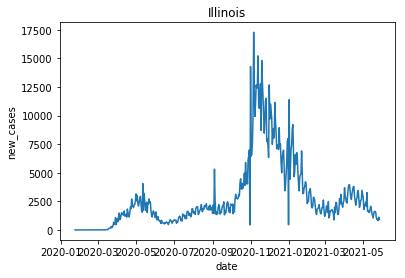

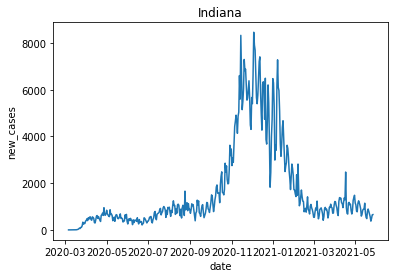

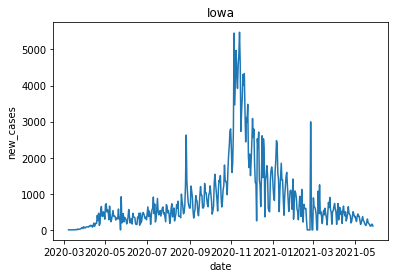

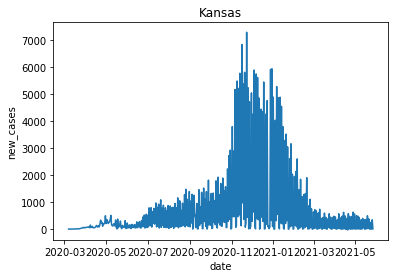

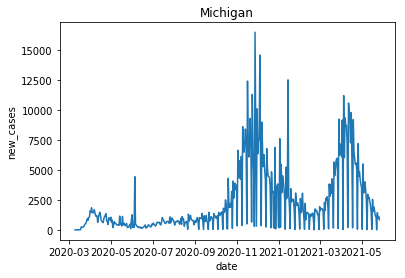

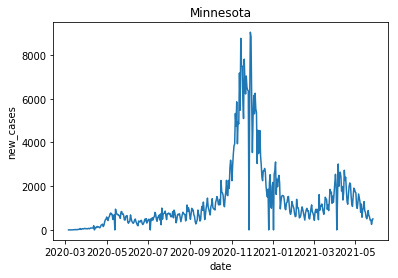

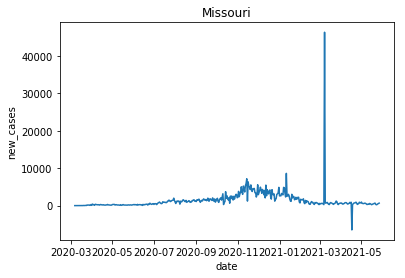

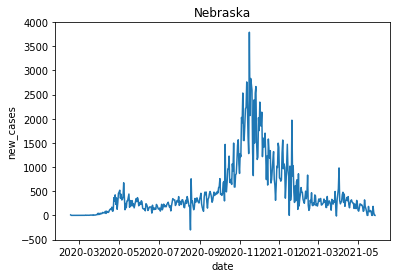

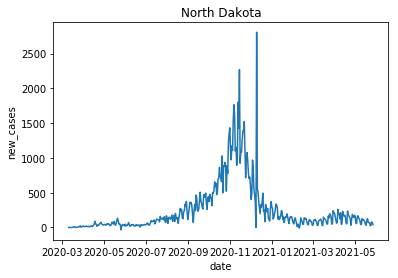

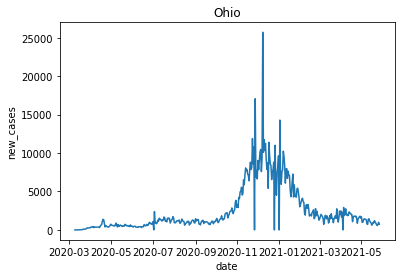

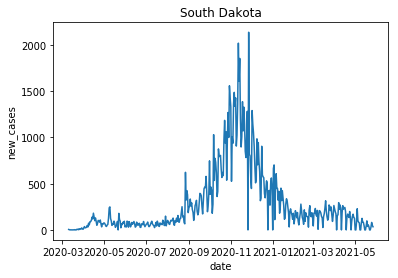

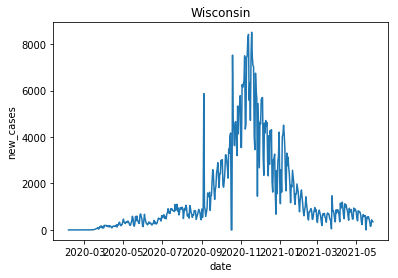

In [23]:
NYT_midwest_states_plt = NYT_midwest.groupby(["state", "date"]).agg("sum")

NYT_midwest_states_plt.reset_index(inplace=True)
NYT_midwest_states_plt.set_index("date", inplace=True)

for state in midwest_states:
    plt.figure()
    plt_data = NYT_midwest_states_plt[NYT_midwest_states_plt["state"]==state]
    sns.lineplot(data=plt_data, x=plt_data.index, y="new_cases")
    plt.title(state)

In [24]:
# investigate negative cases
# NYT_midwest[(NYT_midwest["new_cases"]<0) & (NYT_midwest["county"]!= "Unknown")].sort_values(by=["new_cases"])
# NYT_midwest_imputed[(NYT_midwest_imputed["new_cases"]<0) & (NYT_midwest_imputed["county"]!= "Unknown")].sort_values(by=["new_cases"])

Checked a few outliers:
- Missouri 3/8/2021: The state decided to report a bunch of positive tests they weren't previously counting
- Spot checked some negative new cases/deaths, and it seems like the new cases/deaths calculation is correct and the issues are with the original raw cumulative values
- Checked the noise for Kansas and Michigan and it seems present in the raw data


Now let's check missingness by county

In [25]:
print("# counties in the dataset for the midwest: %d" % len(NYT_midwest[["county", "state"]].drop_duplicates()))
print("# days covered in this data: %d" % len(NYT_midwest["date"].unique()))

# counties in the dataset for the midwest: 1055
# days covered in this data: 490


In [26]:
NYT_midwest.describe()

,cumulative_cases,cumulative_deaths,new_cases,new_deaths
count,437988.00,437988.00,437988.00,437988.00
mean,2968.10,53.92,16.55,0.27
std,12964.03,278.38,79.67,2.10
min,1.00,0.00,-1789.00,-155.00
25%,68.00,1.00,0.00,0.00
50%,490.00,8.00,2.00,0.00
75%,1930.00,35.00,9.00,0.00
max,552466.00,10816.00,10809.00,277.00


In [27]:
pd.set_option('display.max_rows', None)
NYT_midwest.groupby(["state", "county"]).count().describe()

,fips,date,cumulative_cases,cumulative_deaths,new_cases,new_deaths
count,1055.00,1055.00,1055.00,1055.00,1055.00,1055.00
mean,415.15,415.15,415.15,415.15,415.15,415.15
std,30.40,30.40,30.40,30.40,30.40,30.40
min,236.00,236.00,236.00,236.00,236.00,236.00
25%,412.00,412.00,412.00,412.00,412.00,412.00
50%,425.00,425.00,425.00,425.00,425.00,425.00
75%,432.00,432.00,432.00,432.00,432.00,432.00
max,490.00,490.00,490.00,490.00,490.00,490.00


I'm assuming each state/county started reported covid data at different dates, which is fine since it seems like most counties report data for at least a year (besides unknowns).  Spot checked a few of the counties with less days of data are smaller counties that didn't have any cases until later.

### Data Summary and To Dos

#### Summary
- Data seems pretty complete and everything looks good for using this data

### Standardize cases data

In [28]:
NYT_midwest.head()

,state,fips,county,date,cumulative_cases,cumulative_deaths,new_cases,new_deaths
316,Illinois,17001,Adams,2020-03-20,1,0.00,1.00,0.00
317,Illinois,17001,Adams,2020-03-21,1,0.00,0.00,0.00
318,Illinois,17001,Adams,2020-03-22,1,0.00,0.00,0.00
319,Illinois,17001,Adams,2020-03-23,1,0.00,0.00,0.00
320,Illinois,17001,Adams,2020-03-24,1,0.00,0.00,0.00


In [29]:
# smooth out MO 3-8-21 spike and OH 12-8-21 spike
MO_spike = (NYT_midwest["date"]=='2021-03-08') & (NYT_midwest["state"]=="Missouri")
OH_spike = (NYT_midwest["date"]=='2020-12-08') & (NYT_midwest["state"]=="Ohio")
NYT_midwest.loc[(MO_spike | OH_spike), "cumulative_cases":"new_deaths"] = np.NaN
NYT_midwest = NYT_midwest.groupby(["state", "fips", "county"])\
                         .apply(lambda group: group.interpolate(method='linear'))

In [30]:
# interpolate negative new_cases or new_deaths
NYT_midwest.loc[(NYT_midwest["new_cases"]<0), "new_cases"] = np.NaN
NYT_midwest.loc[(NYT_midwest["new_deaths"]<0), "new_deaths"] = np.NaN

NYT_midwest = NYT_midwest.groupby(["state", "fips", "county"])\
                         .apply(lambda group: group.interpolate(method='linear'))

In [31]:
# compute 7 day average
NYT_7avg = NYT_midwest[["state", "date", "fips", "county", "new_cases", "new_deaths"]]\
    .set_index("date")\
    .groupby(["state", "fips", "county"])\
    .rolling(7, min_periods=1).mean().round(0).reset_index()\
    .rename(columns={'new_cases': 'new_cases_7avg', 
                     'new_deaths': 'new_deaths_7avg'})

# merge on 7 day average
NYT_clean = NYT_midwest.merge(NYT_7avg, on=["state", "fips", "date", "county"])

# calculate 2 week lag variables
NYT_clean["2weeksago_cases_7avg"]= NYT_clean.groupby(["state", "fips", "county"])['new_cases_7avg']\
                                            .shift(14)

NYT_clean["2weeksago_cases_7avg"] = NYT_clean["2weeksago_cases_7avg"].fillna(0)

NYT_clean["2weeksago_deaths_7avg"]= NYT_clean.groupby(["state", "fips", "county"])['new_deaths_7avg']\
                                            .shift(14)

NYT_clean["2weeksago_deaths_7avg"] = NYT_clean["2weeksago_deaths_7avg"].fillna(0)

# check that things were computed correctly
NYT_clean[(NYT_clean["fips"]=="17031") & (NYT_clean["date"]>"2020-07-01")].head(30)

,state,fips,county,date,cumulative_cases,cumulative_deaths,new_cases,new_deaths,new_cases_7avg,new_deaths_7avg,2weeksago_cases_7avg,2weeksago_deaths_7avg
6464,Illinois,17031,Cook,2020-07-02,91381.00,4609.00,470.00,28.00,390.00,16.00,314.00,32.00
6465,Illinois,17031,Cook,2020-07-03,91774.00,4618.00,393.00,9.00,387.00,13.00,329.00,29.00
6466,Illinois,17031,Cook,2020-07-04,92240.00,4622.00,466.00,4.00,405.00,12.00,329.00,31.00
6467,Illinois,17031,Cook,2020-07-05,92532.00,4627.00,292.00,5.00,397.00,12.00,324.00,31.00
6468,Illinois,17031,Cook,2020-07-06,92781.00,4630.00,249.00,3.00,380.00,11.00,320.00,31.00
6469,Illinois,17031,Cook,2020-07-07,93053.00,4651.00,272.00,21.00,360.00,12.00,321.00,27.00
6470,Illinois,17031,Cook,2020-07-08,93496.00,4664.00,443.00,13.00,369.00,12.00,326.00,25.00
6471,Illinois,17031,Cook,2020-07-09,94005.00,4676.00,509.00,12.00,375.00,10.00,353.00,24.00
6472,Illinois,17031,Cook,2020-07-10,94605.00,4693.00,600.00,17.00,404.00,11.00,360.00,23.00
6473,Illinois,17031,Cook,2020-07-11,95138.00,4711.00,533.00,18.00,414.00,13.00,360.00,21.00


In [32]:
# Narrow down to just the four states
NYT_clean = NYT_clean[NYT_clean["state"].isin(project_state_names)]
np.unique(NYT_clean["state"])

array(['Illinois', 'Michigan', 'Missouri', 'Ohio'], dtype=object)

In [33]:
# make state abbreviations
NYT_clean['state_abbr'] = "IL"
NYT_clean.loc[NYT_clean['state']=="Missouri", 'state_abbr'] = 'MO'
NYT_clean.loc[NYT_clean['state']=="Ohio", 'state_abbr'] = 'OH'
NYT_clean.loc[NYT_clean['state']=="Michigan", 'state_abbr'] = 'MI'

# make sure things mapped correctly
print(NYT_clean[["state_abbr", "state"]].drop_duplicates())

# rename
NYT_clean = NYT_clean.drop(columns=["state"]).rename(columns={"state_abbr": "state"})
NYT_clean = NYT_clean[NYT_clean.columns.tolist()[-1:] + NYT_clean.columns.tolist()[:-1]]

       state_abbr     state
0              IL  Illinois
166393         MI  Michigan
238251         MO  Missouri
343247         OH      Ohio


In [34]:
# export to folder
NYT_clean.to_csv("../Data/NYT_clean.csv", index=False)

## Variant Data from Helix

From Helix documentation: "Drawing from samples collected during routine lower-nasal swab COVID-19 testing, typically at Helix-supported testing sites across the country, a subset of positive samples are chosen for follow-on sequencing based on demographics, sample quality, test characteristics, or simply random selection."

Because Helix only sequences a sample of their positive cases, I think we should only use Helix for the "Number of positive test results with S gene target failure" (variable name "all_SGTF") and not the variables involving sequencing.  S gene target failure is theorized to be a marker for B117 but it's definitely not exact, but I think as good as we can do with this data. (https://jamanetwork.com/journals/jama/fullarticle/2778599)

This data is also on the state level rather than the county level.

In [28]:
helix = pd.read_csv("../Raw_Data/helix.csv", parse_dates=["collection_date"])
helix.head()

,state,collection_date,positive,all_SGTF,sequenced_SGTF,B117
0,PR,2020-09-05,3,0,0,0
1,VA,2020-09-05,3,0,0,0
2,FL,2020-09-06,8,0,0,0
3,CA,2020-09-07,8,0,0,0
4,AL,2020-09-08,3,0,0,0


In [29]:
helix.shape

(3927, 6)

In [30]:
helix_midwest = helix[helix["state"].isin(midwest_abbrs)]
helix_midwest.shape

(978, 6)

In [31]:
helix_midwest.head()

,state,collection_date,positive,all_SGTF,sequenced_SGTF,B117
7,IL,2020-09-08,4,0,0,0
9,MO,2020-09-08,3,0,0,0
10,OH,2020-09-08,3,0,0,0
26,MN,2020-09-12,4,0,0,0
38,IL,2020-09-15,6,0,0,0


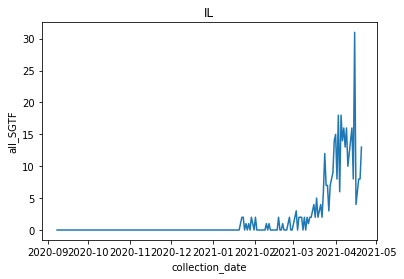

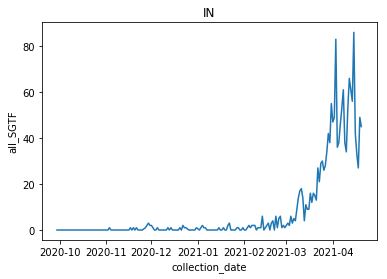

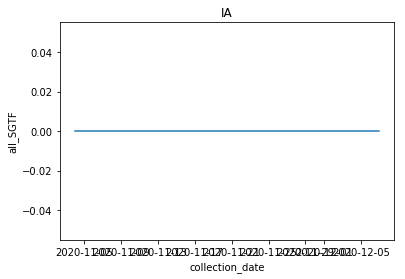

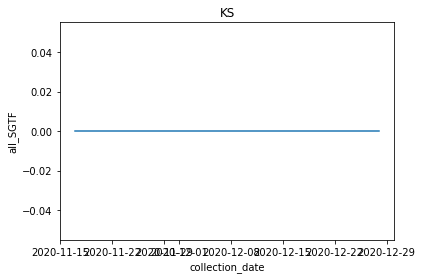

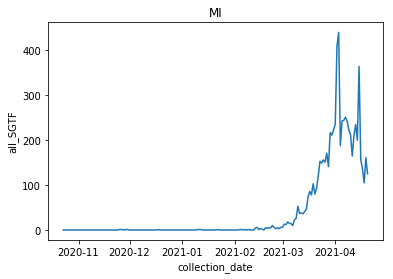

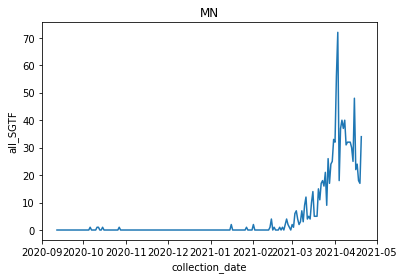

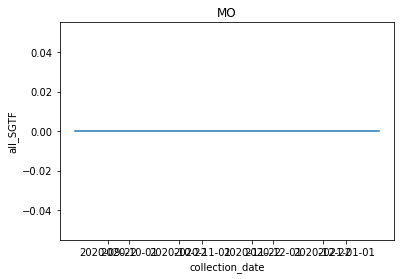

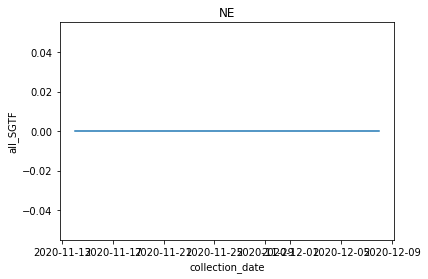

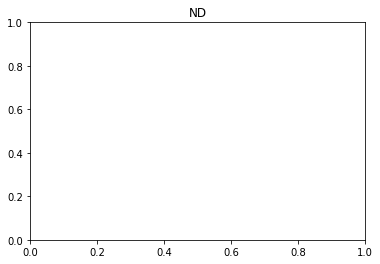

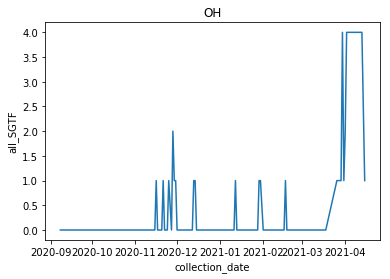

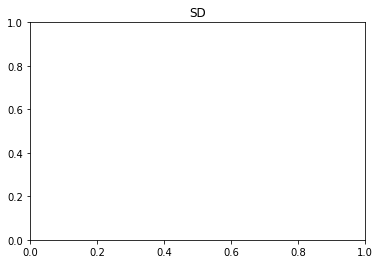

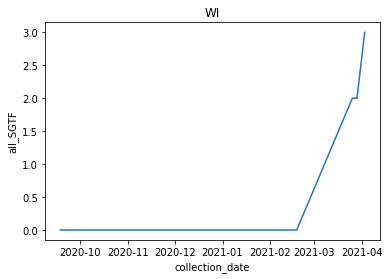

In [32]:
helix_midwest.set_index("collection_date", inplace=True)
for state in midwest_abbrs:
    plt.figure()
    plt_data = helix_midwest[helix_midwest["state"]==state]
    sns.lineplot(data=plt_data, x=plt_data.index, y="all_SGTF")
    plt.title(state)

In [33]:
# check whether SD and ND are just absent from the data
np.unique(helix_midwest.state)

array(['IA', 'IL', 'IN', 'KS', 'MI', 'MN', 'MO', 'NE', 'OH', 'WI'],
      dtype=object)

So it appears that North Dakota and South Dakota are just absent from this Helix data.  This would be an issue if we were to use Helix as the only form of variant data.

Looks like the rate of variants is just very varied across states generally

In [34]:
# let's make cumulative columns
cumulative_all_SGTF = helix_midwest[["state", "all_SGTF", "B117"]].groupby(['state','collection_date']).sum() \
                                                          .groupby(level=0).cumsum().reset_index()
cumulative_all_SGTF.rename(columns={"all_SGTF": "cumulative_SGTF", "B117" : "cumulative_B117"}, inplace=True)

helix_midwest = helix_midwest.merge(cumulative_all_SGTF, on=["state", "collection_date"])

helix_midwest.head()

,state,collection_date,positive,all_SGTF,sequenced_SGTF,B117,cumulative_SGTF,cumulative_B117
0,IL,2020-09-08,4,0,0,0,0,0
1,MO,2020-09-08,3,0,0,0,0,0
2,OH,2020-09-08,3,0,0,0,0,0
3,MN,2020-09-12,4,0,0,0,0,0
4,IL,2020-09-15,6,0,0,0,0,0


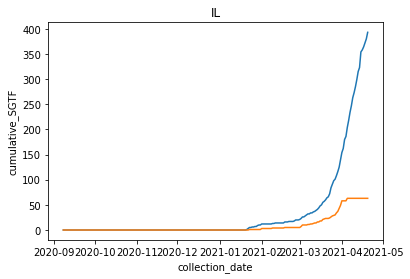

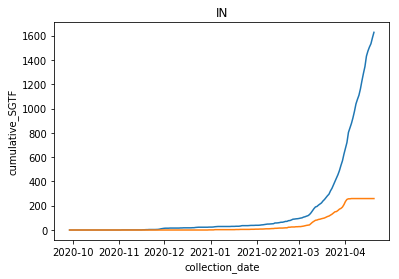

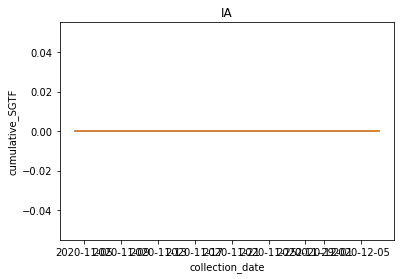

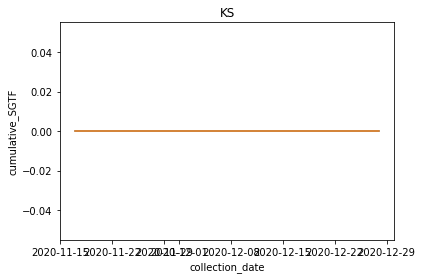

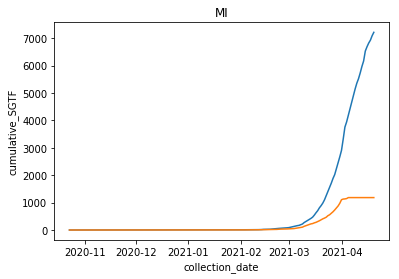

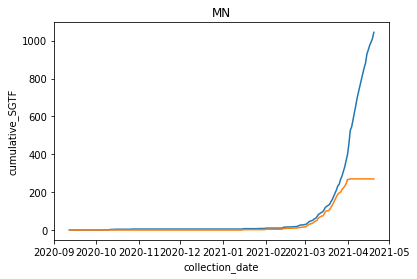

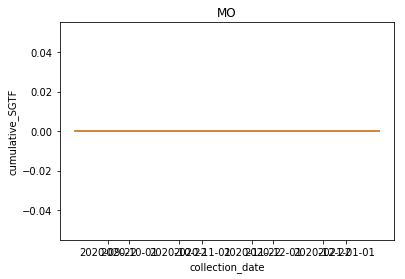

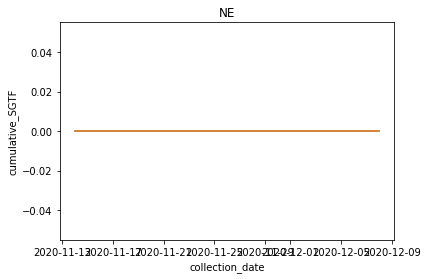

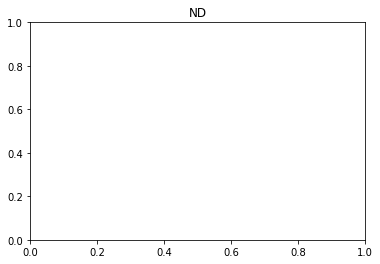

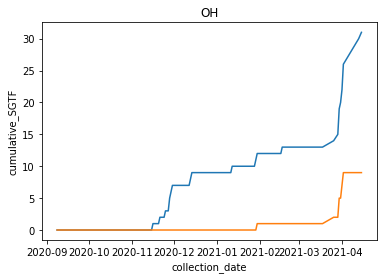

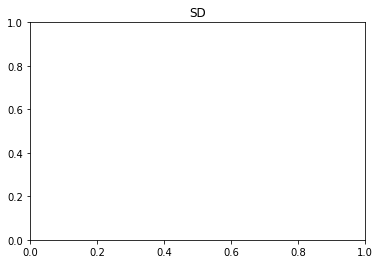

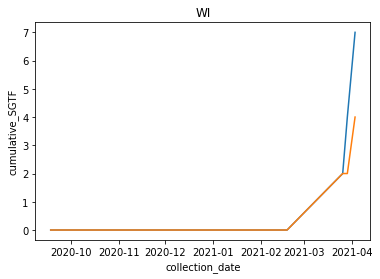

In [35]:
helix_midwest.set_index("collection_date", inplace=True)
for state in midwest_abbrs:
    plt.figure()
    plt_data = helix_midwest[helix_midwest["state"]==state]
    sns.lineplot(data=plt_data, x=plt_data.index, y="cumulative_SGTF")
    sns.lineplot(data=plt_data, x=plt_data.index, y="cumulative_B117")
    plt.title(state)

I don't think the Wisconsin data is complete because this data reports that they only have a handful of variant cases but the Wisconsin DHS definitely reports a lot more (https://www.dhs.wisconsin.gov/covid-19/variants.htm).

### Data Summary and To Dos

#### Summary
- Data is missing for ND and SD entirely
- Data looks very incomplete for Wisconsin
- Generally data seems a pretty unreliable upon matching against CDC current cumulative numbers: https://www.cdc.gov/coronavirus/2019-ncov/transmission/variant-cases.html Doesn't seem like it's a consistant subsample across states so not sure how usable this is...

#### To Do:
- Maybe check the CDC page again for their data?  Or hopefully the GISAid data will be more helpful

## CMS Data on Public Mask Mandates

Source: https://data.cdc.gov/Policy-Surveillance/U-S-State-and-Territorial-Public-Mask-Mandates-Fro/62d6-pm5i
"State and territorial executive orders, administrative orders, resolutions, and proclamations are collected from government websites" 

In [36]:
Masks_df = pd.read_csv("../Raw_Data/CMS-Public_Mask_Mandates.csv", parse_dates=["date"])
Masks_df.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (8,9,10,11,13,14,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Current_order_status,Jurisdiction_Type,Issuing_Jurisdiction,Face_Masks_Required_in_Public,Effective_date,Expiration_date,Effective_NA_Reason,Expiration_NA_Reason,Date_Signed,origin_dataset,Source_of_Action,URL,Citation
0,AL,Autauga County,1,1,2020-04-10,2,No Public Mask Mandate,State,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AL,Autauga County,1,1,2020-04-11,2,No Public Mask Mandate,State,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AL,Autauga County,1,1,2020-04-12,2,No Public Mask Mandate,State,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AL,Autauga County,1,1,2020-04-13,2,No Public Mask Mandate,State,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AL,Autauga County,1,1,2020-04-14,2,No Public Mask Mandate,State,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lots of interesting variables.  Let's explore...

In [37]:
Midwest_Masks_df = Masks_df[Masks_df["State_Tribe_Territory"].isin(midwest_abbrs)]
Midwest_Masks_df.shape

(366085, 19)

In [38]:
# Let's look at the types of mask orders
np.unique(Midwest_Masks_df.Current_order_status) # okay so basically just a binary

array(['No Public Mask Mandate', 'Public Mask Mandate'], dtype=object)

In [39]:
# Let's look at the different jurisdiction types
np.unique(Midwest_Masks_df.Jurisdiction_Type) # hmmmm just state

array(['State'], dtype=object)

In [40]:
# Let's look at the different jurisdiction types for all states
np.unique(Masks_df.Jurisdiction_Type) # okay so basically just literally state or territory level

array(['District (state)', 'State', 'Territory'], dtype=object)

In [41]:
Masks_df[Masks_df["Jurisdiction_Type"]=="District (state)"].head(3)

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Current_order_status,Jurisdiction_Type,Issuing_Jurisdiction,Face_Masks_Required_in_Public,Effective_date,Expiration_date,Effective_NA_Reason,Expiration_NA_Reason,Date_Signed,origin_dataset,Source_of_Action,URL,Citation
84890,DC,District of Columbia,11,1,2020-05-16,1,Public Mask Mandate,District (state),DC,Yes,2020-05-16,2020-06-08,NaN,NaN,2020-05-13,state.terr,Official,https://www.dcregs.dc.gov/Common/NoticeDetail....,"D.C. Mayor's Order No. 2020-066 (May 13, 2020)"
84891,DC,District of Columbia,11,1,2020-05-17,1,Public Mask Mandate,District (state),DC,Yes,2020-05-16,2020-06-08,NaN,NaN,2020-05-13,state.terr,Official,https://www.dcregs.dc.gov/Common/NoticeDetail....,"D.C. Mayor's Order No. 2020-066 (May 13, 2020)"
84892,DC,District of Columbia,11,1,2020-05-18,1,Public Mask Mandate,District (state),DC,Yes,2020-05-16,2020-06-08,NaN,NaN,2020-05-13,state.terr,Official,https://www.dcregs.dc.gov/Common/NoticeDetail....,"D.C. Mayor's Order No. 2020-066 (May 13, 2020)"


In [42]:
Masks_df[Masks_df["Jurisdiction_Type"]=="Territory"].head(3)

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Current_order_status,Jurisdiction_Type,Issuing_Jurisdiction,Face_Masks_Required_in_Public,Effective_date,Expiration_date,Effective_NA_Reason,Expiration_NA_Reason,Date_Signed,origin_dataset,Source_of_Action,URL,Citation
835772,AS,Eastern District,60,10,2020-04-10,2,No Public Mask Mandate,Territory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
835773,AS,Eastern District,60,10,2020-04-11,2,No Public Mask Mandate,Territory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
835774,AS,Eastern District,60,10,2020-04-12,2,No Public Mask Mandate,Territory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Soooo basically this data is on the state level.  Which is still helpful.  Let's just check dates/trends

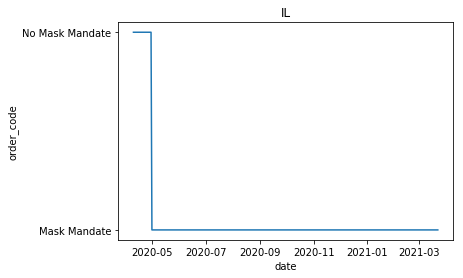

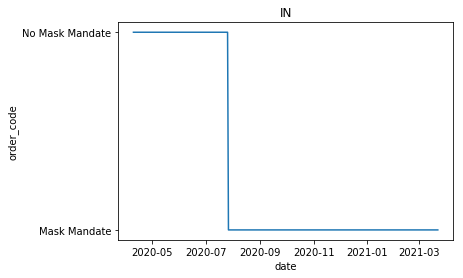

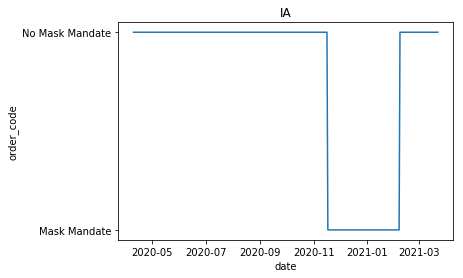

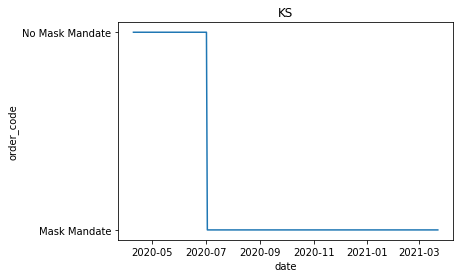

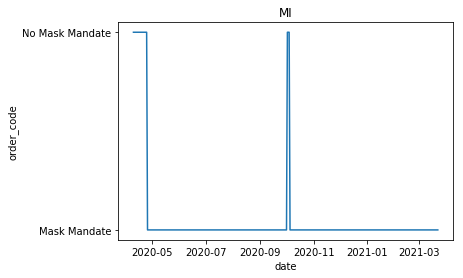

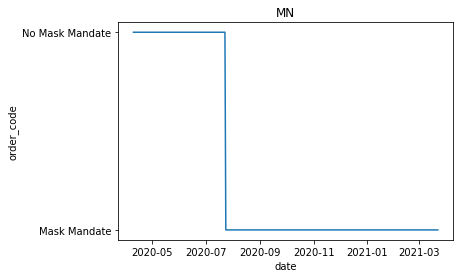

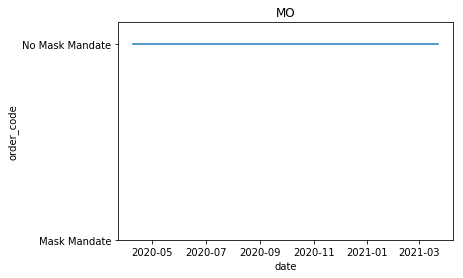

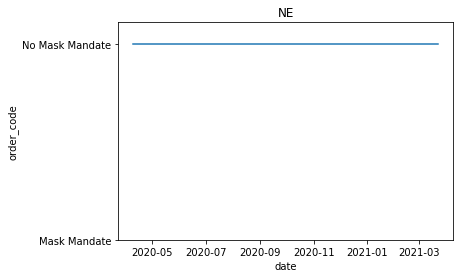

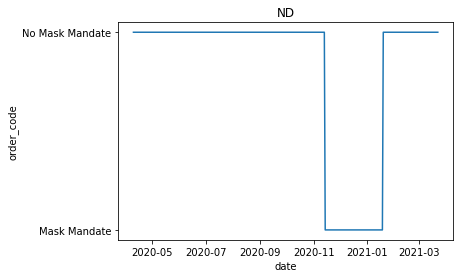

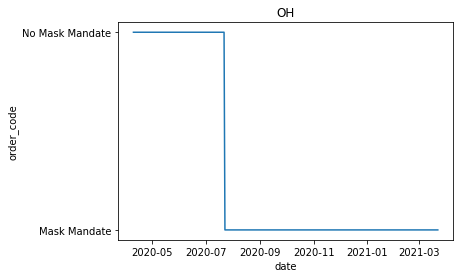

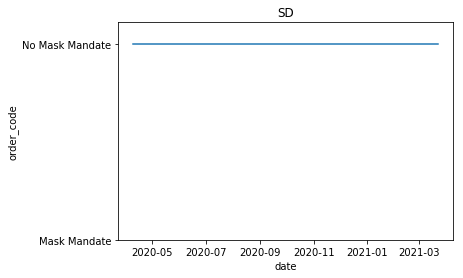

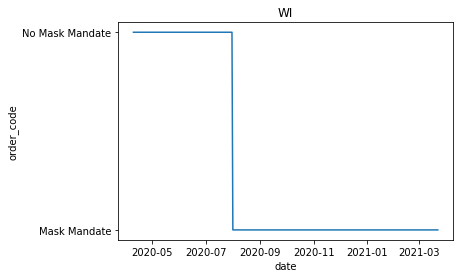

In [43]:
Midwest_Masks_df_states = Midwest_Masks_df[["date", "State_Tribe_Territory", "order_code"]].groupby(["date", "State_Tribe_Territory"]).max()
Midwest_Masks_df_states.reset_index(inplace=True)

Midwest_Masks_df_states.set_index("date", inplace=True)
for state in midwest_abbrs:
    plt.figure()
    plt_data = Midwest_Masks_df_states[Midwest_Masks_df_states["State_Tribe_Territory"]==state]
    sns.lineplot(data=plt_data, x=plt_data.index, y="order_code")
    plt.title(state)
    plt.yticks([1,2], labels=["Mask Mandate", "No Mask Mandate"])

In [44]:
# Let's investigate the random blip in Michigan
pd.set_option('display.max_rows', None)
Midwest_Masks_df[(Midwest_Masks_df["State_Tribe_Territory"]=="MI") & \
                 (Midwest_Masks_df["County_Name"]=="Alcona County") & \
                 (Midwest_Masks_df["date"] < '2020-10-10') & \
                 (Midwest_Masks_df["date"] > '2020-9-30')]
# I think this checks out against articles about the state mandate and then the Health Order

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Current_order_status,Jurisdiction_Type,Issuing_Jurisdiction,Face_Masks_Required_in_Public,Effective_date,Expiration_date,Effective_NA_Reason,Expiration_NA_Reason,Date_Signed,origin_dataset,Source_of_Action,URL,Citation
327620,MI,Alcona County,26,1,2020-10-01,1,Public Mask Mandate,State,MI,Yes,2020-09-25,NaN,NaN,Not listed,2020-09-25,state.terr,Official,https://legislature.mi.gov/documents/2019-2020...,"Mich. Exec. Order No. 2020-184 (Sept. 25, 2020)"
327621,MI,Alcona County,26,1,2020-10-02,2,No Public Mask Mandate,State,MI,No,2020-10-02,NaN,NaN,NaN,2020-10-02,state.terr,Official,https://courts.michigan.gov/Courts/MichiganSup...,In re Certified Questions from the United Stat...
327622,MI,Alcona County,26,1,2020-10-03,2,No Public Mask Mandate,State,MI,No,2020-10-02,NaN,NaN,NaN,2020-10-02,state.terr,Official,https://courts.michigan.gov/Courts/MichiganSup...,In re Certified Questions from the United Stat...
327623,MI,Alcona County,26,1,2020-10-04,2,No Public Mask Mandate,State,MI,No,2020-10-02,NaN,NaN,NaN,2020-10-02,state.terr,Official,https://courts.michigan.gov/Courts/MichiganSup...,In re Certified Questions from the United Stat...
327624,MI,Alcona County,26,1,2020-10-05,1,Public Mask Mandate,State,MI,Yes,2020-10-05,2020-10-30,NaN,NaN,2020-10-05,state.terr,Official,https://www.michigan.gov/documents/coronavirus...,"Mich. Health Order (Oct. 5, 2020)"
327625,MI,Alcona County,26,1,2020-10-06,1,Public Mask Mandate,State,MI,Yes,2020-10-05,2020-10-30,NaN,NaN,2020-10-05,state.terr,Official,https://www.michigan.gov/documents/coronavirus...,"Mich. Health Order (Oct. 5, 2020)"
327626,MI,Alcona County,26,1,2020-10-07,1,Public Mask Mandate,State,MI,Yes,2020-10-05,2020-10-30,NaN,NaN,2020-10-05,state.terr,Official,https://www.michigan.gov/documents/coronavirus...,"Mich. Health Order (Oct. 5, 2020)"
327627,MI,Alcona County,26,1,2020-10-08,1,Public Mask Mandate,State,MI,Yes,2020-10-05,2020-10-30,NaN,NaN,2020-10-05,state.terr,Official,https://www.michigan.gov/documents/coronavirus...,"Mich. Health Order (Oct. 5, 2020)"
327628,MI,Alcona County,26,1,2020-10-09,1,Public Mask Mandate,State,MI,Yes,2020-10-09,2020-10-30,NaN,NaN,2020-10-09,state.terr,Official,https://www.michigan.gov/documents/coronavirus...,"Mich. Health Order (Oct. 9, 2020)"


### Data Summary and To Dos

#### Summary
- Data is at the state level rather than the county level, which is less granular than expected, but will still be helpful
- Spotchecked for accuracy and data seems pretty consistent

#### To Do:
- Think about whether we want to use the lagged version of this for features

### Standardize data

In [45]:
Midwest_Masks_clean = Midwest_Masks_df[["State_Tribe_Territory", 
                                        "County_Name", 
                                        "FIPS_State",
                                        "FIPS_County", 
                                        "date", 
                                        "order_code"]]\
                        .rename(columns={"State_Tribe_Territory": "state", "County_Name" : "county"})\
                        .astype({'FIPS_State': 'str', 'FIPS_County': 'str'})

Midwest_Masks_clean["fips"] = Midwest_Masks_clean["FIPS_State"].str.zfill(2) + \
                                Midwest_Masks_clean["FIPS_County"].str.zfill(3)

Midwest_Masks_clean["mask_mandate"] = Midwest_Masks_clean["order_code"]*-1 + 2


Midwest_Masks_clean = Midwest_Masks_clean.drop(columns=["FIPS_State", "FIPS_County", "order_code"])

In [46]:
# Limit to four project states
Masks_clean = Midwest_Masks_clean[Midwest_Masks_clean["state"].isin(project_state_abbrs)]
np.unique(Masks_clean["state"])

array(['IL', 'MI', 'MO', 'OH'], dtype=object)

In [47]:
# remove the word " County" from county
Masks_clean.loc[:,'county'] = Masks_clean['county'].str.replace(' County','')

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [48]:
# export
Masks_clean.to_csv("../Data/Masks_clean.csv", index=False)

## CMS Data on Hospital Utilization

Source: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/anag-cw7u

Data reported on a weekly basis

I think our main variables of interest will be:
- "total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum": Sum of reports of patients currently hospitalized in an adult inpatient bed who have laboratory-confirmed or suspected COVID19. Including those in observation beds reported during the 7-day period.


- "total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum": Sum of reports of patients currently hospitalized in a pediatric inpatient bed, including NICU, PICU, newborn, and nursery, who have laboratory-confirmed COVID-19. Including those in observation beds. Including patients who have both laboratory-confirmed COVID-19 and laboratory confirmed influenza in this field reported in the 7-day period.

In [38]:
Hospitals_df_raw = pd.read_csv("../Raw_Data/CMS-Hospital_Utilization_updated.csv", 
                               parse_dates=["collection_week"], dtype={'zip': 'str', "fips_code":"str"})
Hospitals_df_raw.head()

,hospital_pk,collection_week,state,ccn,hospital_name,address,city,zip,hospital_subtype,fips_code,is_metro_micro,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_covid_7_day_avg,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg,inpatient_beds_7_day_avg,total_icu_beds_7_day_avg,total_staffed_adult_icu_beds_7_day_avg,icu_beds_used_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_avg,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg,staffed_icu_adult_patients_confirmed_covid_7_day_avg,total_patients_hospitalized_confirmed_influenza_7_day_avg,icu_patients_confirmed_influenza_7_day_avg,total_patients_hospitalized_confirmed_influenza_and_covid_7_day_avg,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum,total_patients_hospitalized_confirmed_influenza_7_day_sum,icu_patients_confirmed_influenza_7_day_sum,total_patients_hospitalized_confirmed_influenza_and_covid_7_day_sum,total_beds_7_day_coverage,all_adult_hospital_beds_7_day_coverage,all_adult_hospital_inpatient_beds_7_day_coverage,inpatient_beds_used_7_day_coverage,all_adult_hospital_inpatient_bed_occupied_7_day_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage,total_adult_patients_hospitalized_confirmed_covid_7_day_coverage,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage,total_pediatric_patients_hospitalized_confirmed_covid_7_day_coverage,inpatient_beds_7_day_coverage,total_icu_beds_7_day_coverage,total_staffed_adult_icu_beds_7_day_coverage,icu_beds_used_7_day_coverage,staffed_adult_icu_bed_occupancy_7_day_coverage,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage,staffed_icu_adult_patients_confirmed_covid_7_day_coverage,total_patients_hospitalized_confirmed_influenza_7_day_coverage,icu_patients_confirmed_influenza_7_day_coverage,total_patients_hospitalized_confirmed_influenza_and_covid_7_day_coverage,previous_day_admission_adult_covid_confirmed_7_day_sum,previous_day_admission_adult_covid_confirmed_18-19_7_day_sum,previous_day_admission_adult_covid_confirmed_20-29_7_day_sum,previous_day_admission_adult_covid_confirmed_30-39_7_day_sum,previous_day_admission_adult_covid_confirmed_40-49_7_day_sum,previous_day_admission_adult_covid_confirmed_50-59_7_day_sum,previous_day_admission_adult_covid_confirmed_60-69_7_day_sum,previous_day_admission_adult_covid_confirmed_70-79_7_day_sum,previous_day_admission_adult_covid_confirmed_80+_7_day_sum,previous_day_admission_adult_covid_confirmed_unknown_7_day_sum,previous_day_admission_pediatric_covid_confirmed_7_day_sum,previous_day_covid_ED_visits_7_day_sum,previous_day_admission_adult_covid_suspected_7_day_sum,previous_day_admission_adult_covid_suspected_18-19_7_day_sum,previous_day_admission_adult_covid_suspected_20-29_7_day_sum,previous_day_admission_adult_covid_suspected_30-39_7_day_sum,previous_day_admission_adult_covid_suspected_40-49_7_day_sum,previous_day_admission_adult_covid_suspected_50-59_7_day_sum,previous_day_admission_adult

In [39]:
# filter down to relevant variables
Hospitals_df = Hospitals_df_raw.filter(items = ["collection_week",
                                                  "state",
                                                  "ccn",
                                                  "hospital_name",
                                                  "address",
                                                  "city",
                                                  "zip",
                                                  "fips_code",
                                                  "total_adult_patients_hospitalized_confirmed_covid_7_day_sum",
                                                  "total_pediatric_patients_hospitalized_confirmed_covid_7_day_sum"])

Hospitals_df = Hospitals_df.merge(Hospitals_df_raw.filter(regex = "^previous_day_admission_adult_covid_confirmed"), left_index=True, right_index=True)

Hospitals_df.columns

Index(['collection_week', 'state', 'ccn', 'hospital_name', 'address', 'city',
       'zip', 'fips_code',
       'total_adult_patients_hospitalized_confirmed_covid_7_day_sum',
       'total_pediatric_patients_hospitalized_confirmed_covid_7_day_sum',
       'previous_day_admission_adult_covid_confirmed_7_day_sum',
       'previous_day_admission_adult_covid_confirmed_18-19_7_day_sum',
       'previous_day_admission_adult_covid_confirmed_20-29_7_day_sum',
       'previous_day_admission_adult_covid_confirmed_30-39_7_day_sum',
       'previous_day_admission_adult_covid_confirmed_40-49_7_day_sum',
       'previous_day_admission_adult_covid_confirmed_50-59_7_day_sum',
       'previous_day_admission_adult_covid_confirmed_60-69_7_day_sum',
       'previous_day_admission_adult_covid_confirmed_70-79_7_day_sum',
       'previous_day_admission_adult_covid_confirmed_80+_7_day_sum',
       'previous_day_admission_adult_covid_confirmed_unknown_7_day_sum',
       'previous_day_admission_adult_covid_conf

In [40]:
# shorten variable names
Hospitals_df.columns = Hospitals_df.columns\
                                   .str.replace("patients_hospitalized_confirmed_covid_7_day_sum",
                                                "hospitalizations")\
                                   .str.replace("previous_day_admission_adult_covid_confirmed",
                                                "prev_day_adult_admit")\
                                   .str.replace("7_day_sum", "7daysum")

In [41]:
Hospitals_df.dtypes

collection_week                         datetime64[ns]
state                                           object
ccn                                             object
hospital_name                                   object
address                                         object
city                                            object
zip                                             object
fips_code                                       object
total_adult_hospitalizations                   float64
total_pediatric_hospitalizations               float64
prev_day_adult_admit_7daysum                   float64
prev_day_adult_admit_18-19_7daysum             float64
prev_day_adult_admit_20-29_7daysum             float64
prev_day_adult_admit_30-39_7daysum             float64
prev_day_adult_admit_40-49_7daysum             float64
prev_day_adult_admit_50-59_7daysum             float64
prev_day_adult_admit_60-69_7daysum             float64
prev_day_adult_admit_70-79_7daysum             float64
prev_day_a

In [42]:
Hospitals_df.describe(datetime_is_numeric=True)

,collection_week,total_adult_hospitalizations,total_pediatric_hospitalizations,prev_day_adult_admit_7daysum,prev_day_adult_admit_18-19_7daysum,prev_day_adult_admit_20-29_7daysum,prev_day_adult_admit_30-39_7daysum,prev_day_adult_admit_40-49_7daysum,prev_day_adult_admit_50-59_7daysum,prev_day_adult_admit_60-69_7daysum,prev_day_adult_admit_70-79_7daysum,prev_day_adult_admit_80+_7daysum,prev_day_adult_admit_unknown_7daysum,prev_day_adult_admit_7_day_coverage
count,209463,206761.00,206412.00,208015.00,198261.00,198962.00,199380.00,199566.00,199980.00,200421.00,200469.00,200229.00,202143.00,209463.00
mean,2020-12-22 03:13:12.432076288,-65707.78,-36179.29,-196749.64,-38787.14,-171982.23,-203650.76,-229417.03,-249618.51,-256892.26,-257539.03,-250970.87,-25055.97,6.80
min,2020-07-31 00:00:00,-999999.00,-999999.00,-999999.00,-999999.00,-999999.00,-999999.00,-999999.00,-999999.00,-999999.00,-999999.00,-999999.00,-999999.00,0.00
25%,2020-10-09 00:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-999999.00,-999999.00,-999999.00,0.00,7.00
50%,2020-12-25 00:00:00,16.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.00
75%,2021-03-05 00:00:00,83.00,0.00,11.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.00
max,2021-05-14 00:00:00,9071.00,519.00,1075.00,2730.00,80.00,117.00,147.00,209.00,184.00,322.00,252.00,594.00,7.00
std,NaN,247929.00,186738.38,397554.77,193087.86,377365.97,402713.41,420459.38,432794.41,436922.24,437281.55,433574.33,156297.12,0.89


Some negative numbers.  From documentation:

_Suppression is applied to the file for sums and averages less than four (4). In these cases, the field will be replaced with “-999,999”._

Let's just code that as 3 for now

In [43]:
Hospitals_df = Hospitals_df.replace(-999999., 3)

In [44]:
# looks better
Hospitals_df.describe(datetime_is_numeric=True)

,collection_week,total_adult_hospitalizations,total_pediatric_hospitalizations,prev_day_adult_admit_7daysum,prev_day_adult_admit_18-19_7daysum,prev_day_adult_admit_20-29_7daysum,prev_day_adult_admit_30-39_7daysum,prev_day_adult_admit_40-49_7daysum,prev_day_adult_admit_50-59_7daysum,prev_day_adult_admit_60-69_7daysum,prev_day_adult_admit_70-79_7daysum,prev_day_adult_admit_80+_7daysum,prev_day_adult_admit_unknown_7daysum,prev_day_adult_admit_7_day_coverage
count,209463,206761.00,206412.00,208015.00,198261.00,198962.00,199380.00,199566.00,199980.00,200421.00,200469.00,200229.00,202143.00,209463.00
mean,2020-12-22 03:13:12.432076288,78.45,0.85,10.60,0.19,0.71,0.96,1.27,1.95,2.49,2.55,2.27,0.60,6.80
min,2020-07-31 00:00:00,0.00,-40.00,-3.00,0.00,0.00,-1.00,-1.00,-18.00,0.00,0.00,0.00,-33.00,0.00
25%,2020-10-09 00:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.00
50%,2020-12-25 00:00:00,16.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.00
75%,2021-03-05 00:00:00,83.00,0.00,11.00,0.00,0.00,3.00,3.00,3.00,3.00,3.00,3.00,0.00,7.00
max,2021-05-14 00:00:00,9071.00,519.00,1075.00,2730.00,80.00,117.00,147.00,209.00,184.00,322.00,252.00,594.00,7.00
std,NaN,165.83,6.06,23.87,8.88,1.69,2.04,2.74,4.18,4.99,5.45,4.95,8.01,0.89


Data only available form 7-31-2020 onwards

In [45]:
# Let's look at missingness for fips
Hospitals_df[Hospitals_df["fips_code"].isna()].groupby("state").agg({"hospital_name":"count"})

,hospital_name
state,
AK,16
AZ,8
FL,13
HI,12
LA,126
NJ,1
NV,42
OK,6
PR,160


There are some missing fips codes but luckily not for any of the states we're looking at!

In [46]:
# filter down to Midwest hospitals
hosp_midwest = Hospitals_df[Hospitals_df["state"].isin(midwest_abbrs)]
hosp_midwest.shape

(60513, 21)

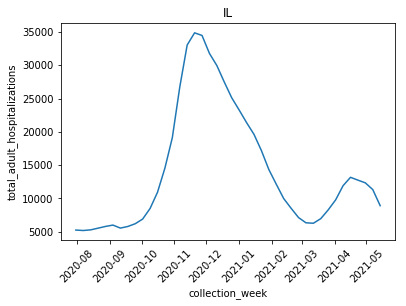

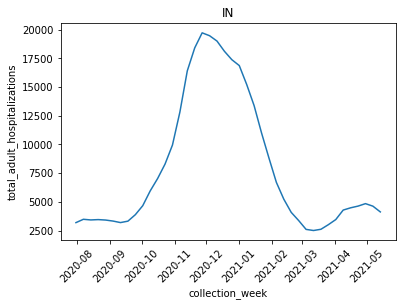

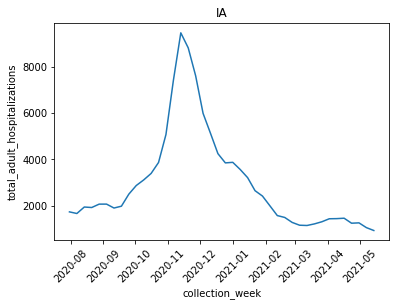

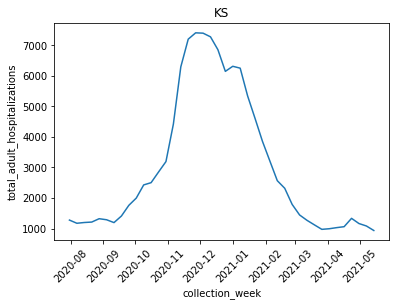

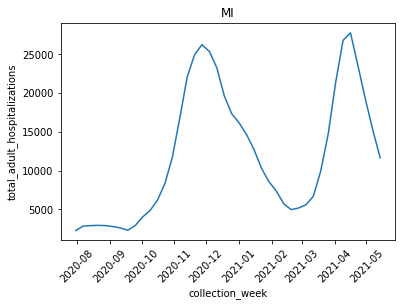

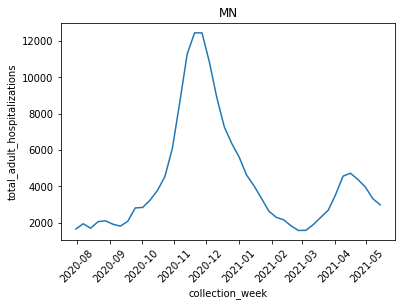

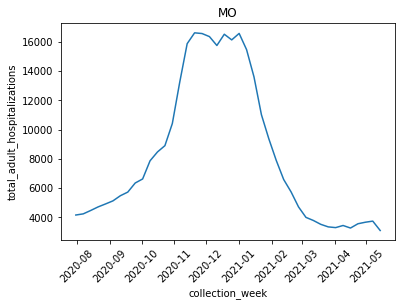

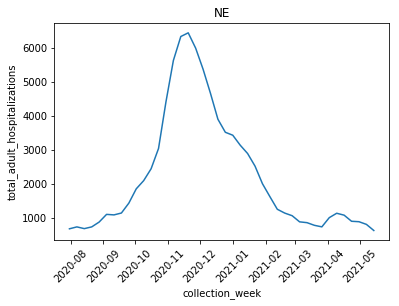

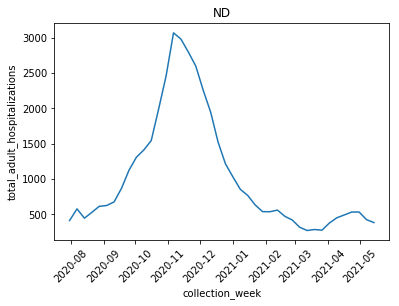

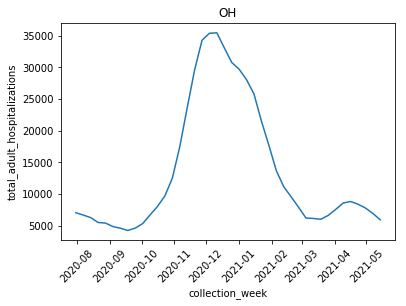

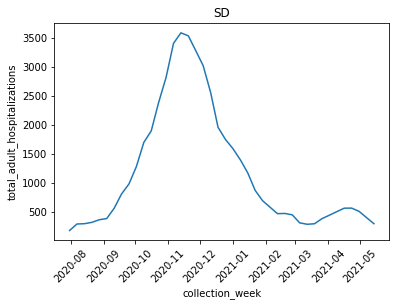

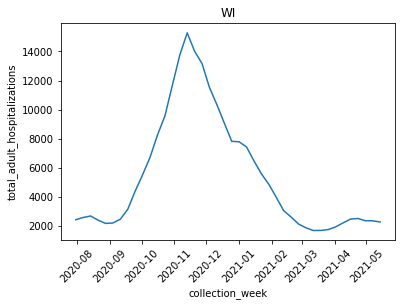

In [47]:
# aggregate and visualize at the state level
hosp_midwest_state_level = hosp_midwest.groupby(["collection_week", "state"]).agg("sum")
hosp_midwest_state_level.reset_index(inplace=True)

hosp_midwest_state_level.set_index("collection_week", inplace=True)
for state in midwest_abbrs:
    plt.figure()
    plt_data = hosp_midwest_state_level[hosp_midwest_state_level["state"]==state]
    sns.lineplot(data=plt_data, x=plt_data.index, y="total_adult_hospitalizations")
    plt.title(state)
    plt.xticks(rotation=45)

### Data Summary and To Dos

#### Summary
- Data looks generally good for using this data for one of our target variables

### Standardize Data

In [48]:
# Narrow down just two the 4 final states
Hospitals_clean = Hospitals_df[Hospitals_df["state"].isin(project_state_abbrs)]

print(Hospitals_clean.shape)

# drop some columns and group by state, date, and county
Hospital_clean = Hospitals_clean.drop(columns=["ccn", "hospital_name", "address", "city", "zip"])
Hospital_clean = Hospitals_clean.groupby(["state", "collection_week", "fips_code"]).agg("sum").reset_index()

# check format
Hospital_clean.head()

(26039, 21)


,state,collection_week,fips_code,total_adult_hospitalizations,total_pediatric_hospitalizations,prev_day_adult_admit_7daysum,prev_day_adult_admit_18-19_7daysum,prev_day_adult_admit_20-29_7daysum,prev_day_adult_admit_30-39_7daysum,prev_day_adult_admit_40-49_7daysum,prev_day_adult_admit_50-59_7daysum,prev_day_adult_admit_60-69_7daysum,prev_day_adult_admit_70-79_7daysum,prev_day_adult_admit_80+_7daysum,prev_day_adult_admit_unknown_7daysum,prev_day_adult_admit_7_day_coverage
0,IL,2020-07-31,17001,73.00,0.00,15.00,0.00,3.00,0.00,3.00,3.00,3.00,7.00,3.00,0.00,7
1,IL,2020-07-31,17005,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5
2,IL,2020-07-31,17011,22.00,0.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.00,3.00,10
3,IL,2020-07-31,17019,129.00,3.00,12.00,0.00,3.00,0.00,0.00,3.00,0.00,4.00,3.00,3.00,13
4,IL,2020-07-31,17021,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,13


In [49]:
# replicate rows so that there's one row per date instead of one row per week
from datetime import timedelta
Hospital_clean = Hospital_clean.loc[Hospital_clean.index.repeat(7)]
Hospital_clean["temp"] = Hospital_clean.groupby(['state','fips_code', 'collection_week']).cumcount()\
                                       .apply(np.ceil).apply(lambda x: pd.Timedelta(x, unit='D'))
Hospital_clean["date"] = Hospital_clean["collection_week"] + Hospital_clean["temp"]

# check to make sure things look right
Hospital_clean[Hospital_clean["fips_code"]=="17001"].head(10)

,state,collection_week,fips_code,total_adult_hospitalizations,total_pediatric_hospitalizations,prev_day_adult_admit_7daysum,prev_day_adult_admit_18-19_7daysum,prev_day_adult_admit_20-29_7daysum,prev_day_adult_admit_30-39_7daysum,prev_day_adult_admit_40-49_7daysum,prev_day_adult_admit_50-59_7daysum,prev_day_adult_admit_60-69_7daysum,prev_day_adult_admit_70-79_7daysum,prev_day_adult_admit_80+_7daysum,prev_day_adult_admit_unknown_7daysum,prev_day_adult_admit_7_day_coverage,temp,date
0,IL,2020-07-31,17001,73.00,0.00,15.00,0.00,3.00,0.00,3.00,3.00,3.00,7.00,3.00,0.00,7,0 days,2020-07-31
0,IL,2020-07-31,17001,73.00,0.00,15.00,0.00,3.00,0.00,3.00,3.00,3.00,7.00,3.00,0.00,7,1 days,2020-08-01
0,IL,2020-07-31,17001,73.00,0.00,15.00,0.00,3.00,0.00,3.00,3.00,3.00,7.00,3.00,0.00,7,2 days,2020-08-02
0,IL,2020-07-31,17001,73.00,0.00,15.00,0.00,3.00,0.00,3.00,3.00,3.00,7.00,3.00,0.00,7,3 days,2020-08-03
0,IL,2020-07-31,17001,73.00,0.00,15.00,0.00,3.00,0.00,3.00,3.00,3.00,7.00,3.00,0.00,7,4 days,2020-08-04
0,IL,2020-07-31,17001,73.00,0.00,15.00,0.00,3.00,0.00,3.00,3.00,3.00,7.00,3.00,0.00,7,5 days,2020-08-05
0,IL,2020-07-31,17001,73.00,0.00,15.00,0.00,3.00,0.00,3.00,3.00,3.00,7.00,3.00,0.00,7,6 days,2020-08-06
76,IL,2020-08-07,17001,106.00,0.00,16.00,0.00,0.00,0.00,4.00,3.00,0.00,3.00,6.00,0.00,7,0 days,2020-08-07
76,IL,2020-08-07,17001,106.00,0.00,16.00,0.00,0.00,0.00,4.00,3.00,0.00,3.00,6.00,0.00,7,1 days,2020-08-08
76,IL,2020-08-07,17001,106.00,0.00,16.00,0.00,0.00,0.00,4.00,3.00,0.00,3.00,6.00,0.00,7,2 days,2020-08-09


In [50]:
# tidy up columms
Hospital_clean = Hospital_clean.drop(columns=["temp", "prev_day_adult_admit_7_day_coverage"])
Hospital_clean = Hospital_clean[Hospital_clean.columns.tolist()[-1:] + Hospital_clean.columns.tolist()[:-1]]
Hospital_clean = Hospital_clean.rename(columns={"fips_code": "fips"})
Hospital_clean = Hospital_clean.sort_values(by=["state", "fips", "date"])
Hospital_clean.head(1)

,date,state,collection_week,fips,total_adult_hospitalizations,total_pediatric_hospitalizations,prev_day_adult_admit_7daysum,prev_day_adult_admit_18-19_7daysum,prev_day_adult_admit_20-29_7daysum,prev_day_adult_admit_30-39_7daysum,prev_day_adult_admit_40-49_7daysum,prev_day_adult_admit_50-59_7daysum,prev_day_adult_admit_60-69_7daysum,prev_day_adult_admit_70-79_7daysum,prev_day_adult_admit_80+_7daysum,prev_day_adult_admit_unknown_7daysum
0,2020-07-31,IL,2020-07-31,17001,73.00,0.00,15.00,0.00,3.00,0.00,3.00,3.00,3.00,7.00,3.00,0.00


In [51]:
# export to Clean Data folder
Hospital_clean.to_csv("../Data/Hospitals_clean.csv", index=False)

## Missouri vaccine administration data

In [54]:
MO_vaccines_raw = pd.read_csv("../Raw_Data/vaccines/MO_Total_Doses_by_County_data_updated.csv", parse_dates=["Date Administered"])
MO_vaccines_raw.head()

,Date Administered,* Jurisdiction,COVID-19 Doses Administered
0,2021-05-27,Out-of-State,292
1,2021-05-26,Out-of-State,584
2,2021-05-25,Out-of-State,499
3,2021-05-24,Out-of-State,540
4,2021-05-23,Out-of-State,170


In [55]:
MO_vaccines = MO_vaccines_raw.rename(columns={"Date Administered": "date", 
                                              "* Jurisdiction": "county",
                                              "COVID-19 Doses Administered": "doses"})

In [56]:
MO_vaccines.describe(datetime_is_numeric=True)

,date,doses
count,18276,18276.00
mean,2021-03-09 10:52:28.522652928,246.82
min,2020-12-13 00:00:00,1.00
25%,2021-01-29 00:00:00,11.00
50%,2021-03-10 00:00:00,41.00
75%,2021-04-18 00:00:00,137.00
max,2021-05-27 00:00:00,12746.00
std,NaN,766.90


data spans 12-13-2020 through 04-25-2021

In [57]:
# let's look at missingness across counties
MO_vaccines.groupby("county").agg("count")

,date,doses
county,,
Adair,161,161
Andrew,154,154
Atchison,122,122
Audrain,158,158
Barry,161,161
Barton,148,148
Bates,153,153
Benton,154,154
Bollinger,147,147


In [74]:
# let's peek at the proportion of unknown counties
unknown_mask = (MO_vaccines["county"]=="Unknown State") | (MO_vaccines["county"]=="Unknown Jurisdiction")
unknown_county = MO_vaccines[unknown_mask][["date", "doses"]].reset_index()
known_county = MO_vaccines[MO_vaccines["county"]!="Unknown"].groupby(["date"]).agg({"doses": "sum"}).reset_index()

In [64]:
unknown_county.head()

,index,date,doses
0,164,2021-05-27,101
1,165,2021-05-26,435
2,166,2021-05-25,492
3,167,2021-05-24,456
4,168,2021-05-23,16


In [65]:
merged_county = known_county.merge(unknown_county, on=["date"], how="left")
merged_county["pct_unknown"] = merged_county["doses_y"]/merged_county["doses_x"]
merged_county.describe()

,doses_x,index,doses_y,pct_unknown
count,329.00,327.00,327.00,327.00
mean,27421.64,327.00,1345.46,0.04
std,19387.35,94.54,1541.08,0.03
min,1.00,164.00,2.00,0.00
25%,12287.00,245.50,312.50,0.02
50%,24053.00,327.00,788.00,0.03
75%,40016.00,408.50,1789.00,0.05
max,82673.00,490.00,10320.00,0.16


Looks like for the most part that the unknown counties only account for 5% of vaccinations or less, so I think we can just drop the unknown county observations

(array([737791., 737822., 737850., 737881., 737911., 737942.]),
 <a list of 6 Text xticklabel objects>)

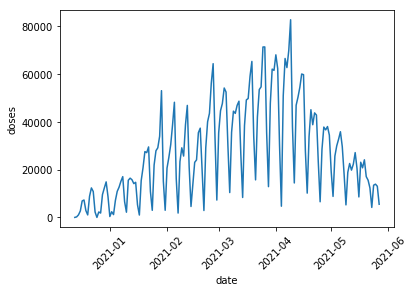

In [66]:
# aggregate and visualize at the state level
MO_vaccines["state"]="MO"
MO_vaccines_plt = MO_vaccines.groupby(["state", "date"]).agg("sum").reset_index()
sns.lineplot(data=MO_vaccines_plt, x="date", y="doses")
plt.xticks(rotation = 45)

Looks like very few vaccines get administered on Sundays.  Otherwise it looks alright.

### Standardize Data

In [82]:
# Let's drop unknown counties (since it's a small % most of the time)
MO_vaccine_clean = MO_vaccines[(MO_vaccines["county"]!="Unknown State") & (MO_vaccines["county"]!="Unknown Jurisdiction")]

# Let's also drop out of state
MO_vaccine_clean = MO_vaccine_clean[MO_vaccine_clean["county"]!="Out-of-State"]

# Let's get a cumulative dose count

MO_vaccine_clean["cumulative doses"] = MO_vaccine_clean.sort_values(by=["state", "county", "date"])\
                                                       .groupby(['state', "county"])['doses'].cumsum(axis=0)

MO_vaccine_clean = MO_vaccine_clean.rename(columns={"doses":"new doses"})

MO_vaccine_clean.sort_values(by=["state", "county", "date"]).head(20)

MO_vaccine_clean = MO_vaccine_clean[["date","state", "county", "new doses", "cumulative doses"]]

MO_vaccine_clean = MO_vaccine_clean.sort_values(by=["state", "county", "date"]).reset_index()

MO_vaccine_clean.head()

,index,date,state,county,new doses,cumulative doses
0,18275,2020-12-14,MO,Adair,1,1
1,18274,2020-12-15,MO,Adair,4,5
2,18273,2020-12-16,MO,Adair,8,13
3,18272,2020-12-17,MO,Adair,16,29
4,18271,2020-12-18,MO,Adair,13,42


In [83]:
MO_county_fips_xwalk = NYT_clean[NYT_clean["state"]=="MO"][["fips", "county"]].drop_duplicates().reset_index()
MO_vaccine_clean = MO_vaccine_clean.merge(MO_county_fips_xwalk, on="county", how="left")

In [84]:
MO_vaccine_clean.loc[MO_vaccine_clean["county"]=="Kansas City", 'fips'] = "29095"
MO_vaccine_clean.loc[MO_vaccine_clean["county"]=="Joplin", 'fips'] = "29097"
MO_vaccine_clean.loc[MO_vaccine_clean["county"]=="St. Louis City", 'fips'] = "29510" # didn't get merged in the xwalk due to capitalization difference

In [85]:
MO_vaccine_clean[MO_vaccine_clean["fips"].isna()]

,index_x,date,state,county,new doses,cumulative doses,index_y,fips


In [86]:
MO_vaccine_clean = MO_vaccine_clean.drop(columns=["index_x", "index_y"])
MO_vaccine_clean.head()

,date,state,county,new doses,cumulative doses,fips
0,2020-12-14,MO,Adair,1,1,29001
1,2020-12-15,MO,Adair,4,5,29001
2,2020-12-16,MO,Adair,8,13,29001
3,2020-12-17,MO,Adair,16,29,29001
4,2020-12-18,MO,Adair,13,42,29001


In [87]:
MO_vaccine_clean.to_csv("../Data/MO_vaccine_clean.csv", index=False)